<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Sun May  3 06:01:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
S12_PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S12'
sys.path.append(S12_PROJECT_PATH+'/S12_Modular_Code/')
import os
os.chdir(S12_PROJECT_PATH+'/S12_Modular_Code/')

In [0]:
from __future__ import print_function
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np
from utils import *

In [0]:
# # To unzip the file
path='/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/tiny-imagenet-200.zip'
!unzip '{path}' -d '/content/tiny_image'

Streaming output truncated to the last 5000 lines.
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: /content/tiny_image/tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: 

In [0]:
# Load tiny Image Dataset
import time
import cv2 as nd
import numpy as np

path = '/content/tiny_image'+'/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [nd.cvtColor(nd.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))),nd.COLOR_BGR2RGB) for i in range(500)]
        train_labels_ = np.array([[value]*1]*500)
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(nd.cvtColor(nd.imread( path + 'val/images/{}'.format(img_name)),nd.COLOR_BGR2RGB))
        test_labels_ = [id_dict[class_id]]
        test_labels += test_labels_

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 12.111303806304932 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 1)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000,)


#Dataloader Arguments & Test/Train Dataloaders


In [0]:
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

In [0]:
from torchDataset import MyDataset

In [0]:
# Converting the data into Dataset
trainset = MyDataset(train_data, train_labels, transform=None)
testset = MyDataset(test_data, test_labels, transform=None)

In [0]:
# # Downloading TrainSet
# trainset = datasets.CIFAR10(root='./data', train=True,
#                                         download=True)
# # Downloading Testset
# testset = datasets.CIFAR10(root='./data', train=False,
#                                        download=True)

In [0]:
# Calculating Mean and Std dev
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
mean, std = get_meanstd(trainset, testset)

print(mean, std)


[0.48042979 0.44819701 0.39755623] [0.27643974 0.26888656 0.28166852]


In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-xj9c2ksx
All libraries are successfully installed!


In [0]:
from Album_Methods import Albumentations as AM

In [0]:
AM().transArguDetails("RandomRotate90", "HorizontalFlip", "ShiftScaleRotate", "GridDistortion", "Normalize")

RandomRotate90 : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
HorizontalFlip : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
ShiftScaleRotate : ArgSpec(args=['self', 'shift_limit', 'scale_limit', 'rotate_limit', 'interpolation', 'border_mode', 'value', 'mask_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(0.0625, 0.1, 45, 1, 4, None, None, False, 0.5)) ,
GridDistortion : ArgSpec(args=['self', 'num_steps', 'distort_limit', 'interpolation', 'border_mode', 'value', 'mask_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(5, 0.3, 1, 4, None, None, False, 0.5)) ,
Normalize : ArgSpec(args=['self', 'mean', 'std', 'max_pixel_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), 255.0, False, 1.0)) ,


In [0]:
train_args= {
'RandomRotate90' : {},
'HorizontalFlip' : {},
'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':45, 'p':.2},
'GridDistortion' : {'num_steps':5},
'Normalize' : {'mean':mean, 'std':std}
}

test_args={
    'Normalize' : {'mean':mean, 'std':std}
}

In [0]:
# Train Phase transformations
train_transforms = AM().transform(**train_args)

# Test Phase transformations
test_transforms = AM().transform(**test_args)

In [0]:
from DataLoader import DataLoader

SEED = 1

# Downloading TrainSet
trainset = MyDataset(train_data, train_labels, transform=train_transforms)

# Downloading Testset
testset = MyDataset(test_data, test_labels,transform=test_transforms)

# Creating object of a class
dataloader= DataLoader(shuffle=True, batch_size=512, seed=SEED, num_workers=2, pin_memory=True)


# split trainset data according to S12 Requirements
trainset,testset = torch.utils.data.random_split(trainset, [int(.70*len(trainset)), int(.30*len(trainset))]) 

# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
# classes in cifar 10
classes = list(get_class_to_id_dict().values())

In [0]:
classes = list(map(lambda x:x[1], classes))

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 64, 64]) tensor([-0.0430, -0.0331, -0.0319]) tensor([0.9706, 0.9715, 0.9667])
organ, pipe organ
 bannister, banister, balustrade, balusters, handrail
 Arabian camel, dromedary, Camelus dromedarius
 goldfish, Carassius auratus
 abacus
 brown bear, bruin, Ursus arctos
 dining table, board
 chain
 punching bag, punch bag, punching ball, punchball
 albatross, mollymawk
 cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM
 sewing machine
 bikini, two-piece
 tarantula
 Persian cat
 pill bottle
 golden retriever
 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
 convertible
 candle, taper, wax light
 binoculars, field glasses, opera glasses
 moving van
 pole
 miniskirt, mini
 bullfrog, Rana catesbeiana
 sea slug, nudibranch
 vestment
 cardigan
 mantis, mantid
 chain
 hog, pig, grunter, squealer, Sus scrofa
 water jug
 confectionery, confectionary, candy store
 gazelle
 sombrero
 b

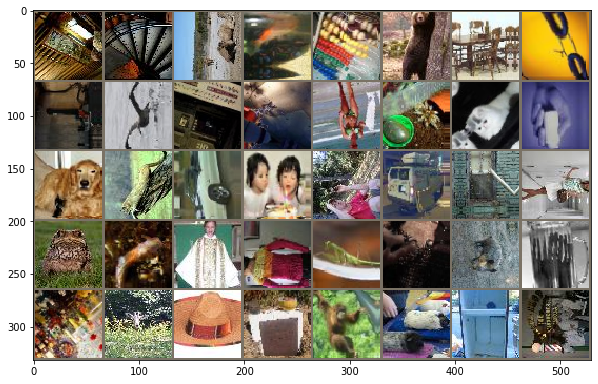

In [0]:
sample_images(trainloader, mean, std, classes, count=40)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

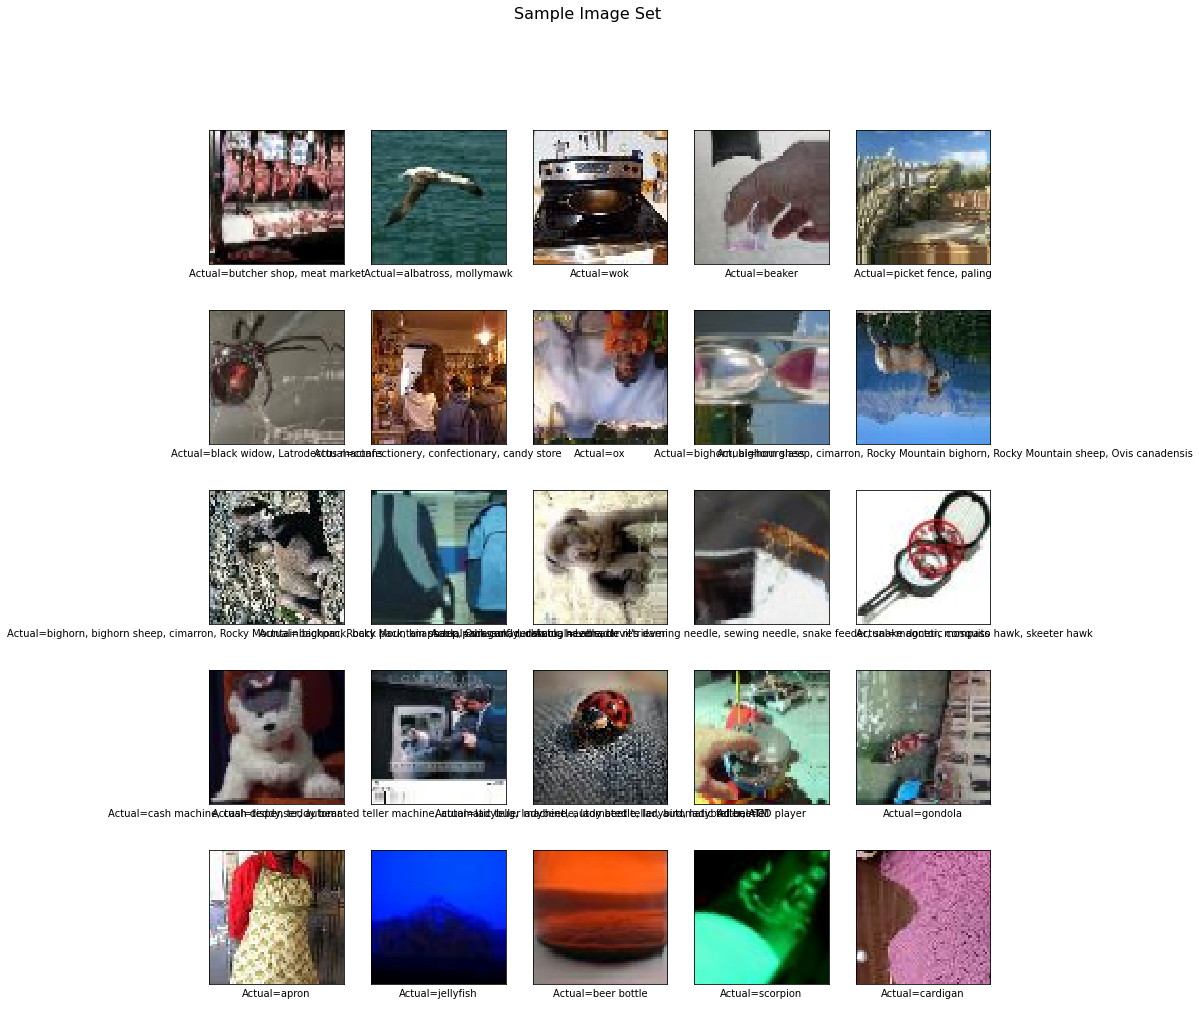

In [0]:
sample_images(trainloader, mean, std, classes, count=25, LabelClarity=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from Model import Resnet_Architecture
model = Resnet_Architecture(Model_Layers=18, name="Model_LR_Finder", num_classes=200)
model.to(dataloader.device)
model.summary(input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from LRFinder import LR_Finder
Loss="CrossEntropyLoss"
EPOCHS = 10
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
lrfinder = LR_Finder(optimizer)
optimizer, scheduler = lrfinder.range_test(start_lr=1e-2, end_lr=3,num_iter=1000, step_mode="exp", smooth_f=0.05, diverge_th=5)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
model.gotrain(optimizer=optimizer, train_loader=trainset, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S12_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=lrfinder, L1lambda=0, LossType=Loss)

  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.111119).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0104, Accuracy: 0.58%; Test set: Average loss: 0.1111, Accuracy: 1.15%
Learning Rate = 0.021971


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.111119 --> 0.104778).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0101, Accuracy: 1.49%; Test set: Average loss: 0.1048, Accuracy: 2.33%
Learning Rate = 0.047996


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.104778 --> 0.101829).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0096, Accuracy: 3.16%; Test set: Average loss: 0.1018, Accuracy: 3.73%
Learning Rate = 0.104851


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.101829 --> 0.100563).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0099, Accuracy: 2.22%; Test set: Average loss: 0.1006, Accuracy: 3.67%
Learning Rate = 0.229055


Batch=575 Loss=5.3015 Acc=0.72%:  19%|█▉        | 26/137 [07:52<33:35, 18.16s/it]

Stopping early, the loss has diverged


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


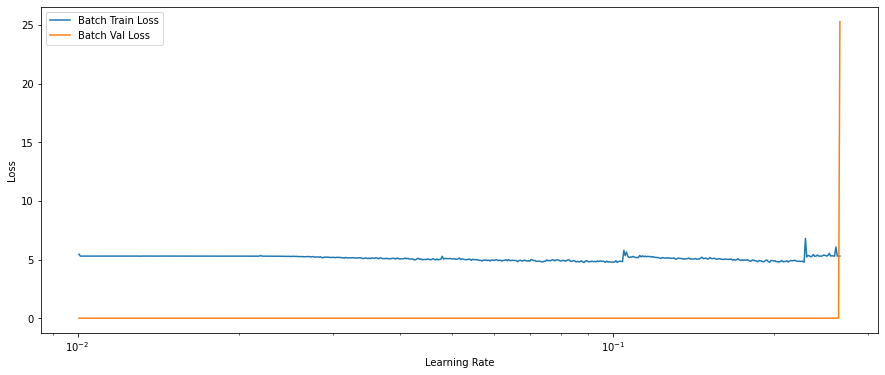

In [0]:
lrfinder.plot(load_path=S12_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_train_loss", "batch_val_loss"], ylabel='Loss', legend_arr=['Batch Train Loss', 'Batch Val Loss'], title='Complete_LR_Finder_Curve', save_path=S12_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=0, log_lr=True)

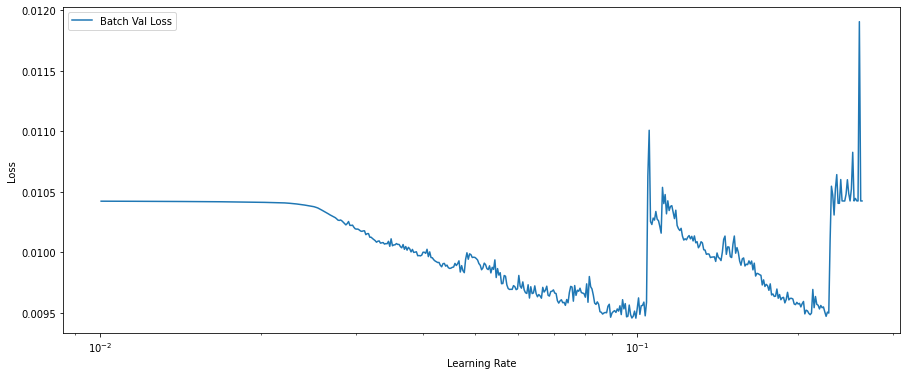

In [0]:
lrfinder.plot(load_path=S12_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_val_loss"], ylabel='Loss', legend_arr=['Batch Val Loss'], title='LR_Finder_Curve', save_path=S12_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=2, log_lr=True)

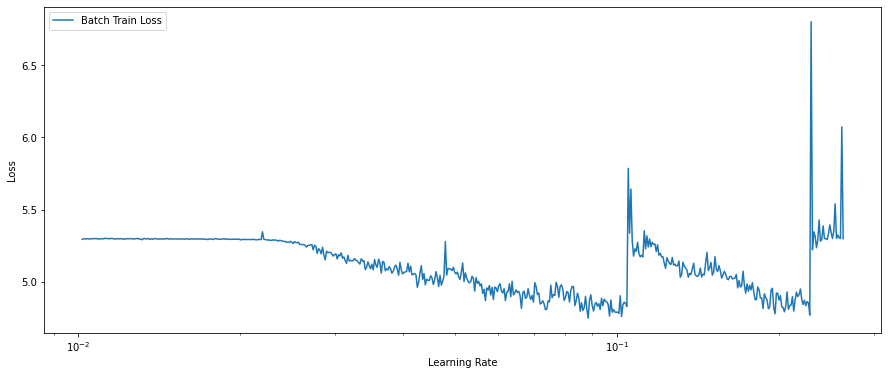

In [0]:
lrfinder.plot(load_path=S12_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_train_loss"], ylabel='Loss', legend_arr=['Batch Train Loss'], title='Train_LR_Finder_Curve', save_path=S12_PROJECT_PATH+"/Save_Model/", skip_start=2, skip_end=2, log_lr=True)

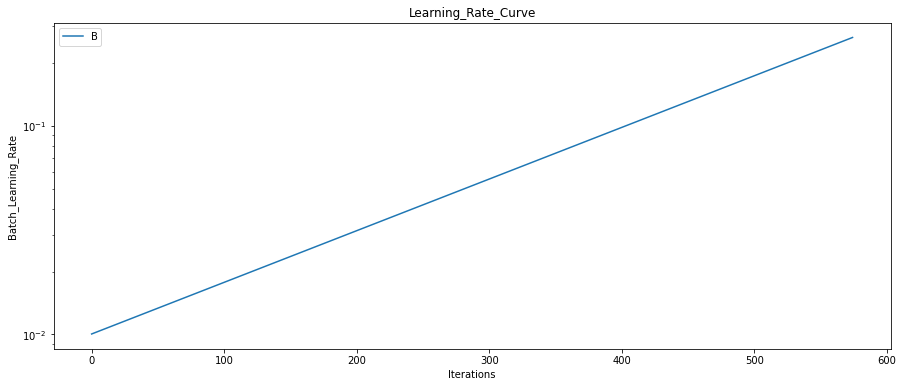

In [0]:
plot_graph(load_path=S12_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json', cols=["batch_lr"], legend_arr='Batch_Learning_Curve', xlabel='Iterations', ylabel='Batch_Learning_Rate', title='Learning_Rate_Curve', save_path=S12_PROJECT_PATH+'/Save_Model/',log=True)

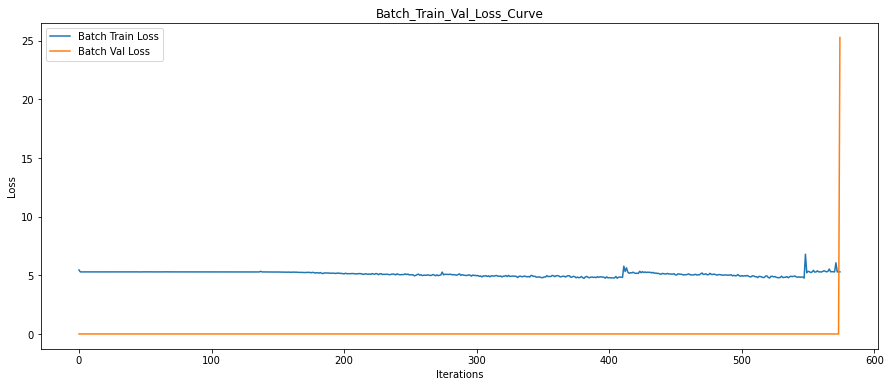

In [0]:
plot_graph(load_path=S12_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json', cols=["batch_train_loss", "batch_val_loss"], legend_arr=['Batch Train Loss', 'Batch Val Loss'], xlabel='Iterations', ylabel='Loss', title='Batch_Train_Val_Loss_Curve', save_path=S12_PROJECT_PATH+'/Save_Model/')


In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = Resnet_Architecture(Model_Layers=18, name="Model_Res", num_classes=200)
model.to(dataloader.device)
Loss="CrossEntropyLoss"
EPOCHS = 30
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=0.100174454672119, weight_decay=0.0019 ,momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.100174454672119, steps_per_epoch=len(trainloader), epochs=EPOCHS,  pct_start=5/EPOCHS, div_factor=100, final_div_factor=8)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S12_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=True, L1lambda=0, LossType=Loss)

Batch=137 Loss=4.5821 Acc=3.32%: 100%|██████████| 137/137 [01:59<00:00,  1.14it/s]


Validation loss decreased (100000.000000 --> 0.279879).  Saving model ...


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 1, Train set: Average loss: 0.0098, Accuracy: 3.32%; Test set: Average loss: 0.2799, Accuracy: 4.94%
Learning Rate = 0.010499


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.279879 --> 0.270836).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0087, Accuracy: 8.10%; Test set: Average loss: 0.2708, Accuracy: 6.99%
Learning Rate = 0.035352


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.270836 --> 0.265286).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0081, Accuracy: 11.83%; Test set: Average loss: 0.2653, Accuracy: 8.88%
Learning Rate = 0.066041


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.265286 --> 0.254203).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0075, Accuracy: 15.68%; Test set: Average loss: 0.2542, Accuracy: 11.33%
Learning Rate = 0.090811


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.254203 --> 0.236145).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0071, Accuracy: 19.22%; Test set: Average loss: 0.2361, Accuracy: 14.20%
Learning Rate = 0.100174


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.236145 --> 0.230671).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0068, Accuracy: 22.10%; Test set: Average loss: 0.2307, Accuracy: 15.74%
Learning Rate = 0.099774


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 7, Train set: Average loss: 0.0065, Accuracy: 24.49%; Test set: Average loss: 0.2520, Accuracy: 13.34%
Learning Rate = 0.098591


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.230671 --> 0.213907).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0063, Accuracy: 26.22%; Test set: Average loss: 0.2139, Accuracy: 19.85%
Learning Rate = 0.096645


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.213907 --> 0.198561).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0061, Accuracy: 28.29%; Test set: Average loss: 0.1986, Accuracy: 24.05%
Learning Rate = 0.093965


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 10, Train set: Average loss: 0.0059, Accuracy: 29.88%; Test set: Average loss: 0.2187, Accuracy: 18.25%
Learning Rate = 0.090594


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 11, Train set: Average loss: 0.0057, Accuracy: 31.38%; Test set: Average loss: 0.2013, Accuracy: 22.69%
Learning Rate = 0.086585


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.198561 --> 0.196845).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0056, Accuracy: 32.68%; Test set: Average loss: 0.1968, Accuracy: 24.37%
Learning Rate = 0.082001


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 13, Train set: Average loss: 0.0055, Accuracy: 34.01%; Test set: Average loss: 0.2124, Accuracy: 20.49%
Learning Rate = 0.076916


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.196845 --> 0.189028).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0054, Accuracy: 35.19%; Test set: Average loss: 0.1890, Accuracy: 26.85%
Learning Rate = 0.071408


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.189028 --> 0.181881).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0053, Accuracy: 36.19%; Test set: Average loss: 0.1819, Accuracy: 28.51%
Learning Rate = 0.065565


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 16, Train set: Average loss: 0.0052, Accuracy: 37.31%; Test set: Average loss: 0.1999, Accuracy: 23.79%
Learning Rate = 0.059478


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.181881 --> 0.177026).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0051, Accuracy: 38.42%; Test set: Average loss: 0.1770, Accuracy: 30.55%
Learning Rate = 0.053245


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch: 18, Train set: Average loss: 0.0049, Accuracy: 39.83%; Test set: Average loss: 0.1832, Accuracy: 28.99%
Learning Rate = 0.046963


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.177026 --> 0.173394).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0048, Accuracy: 41.06%; Test set: Average loss: 0.1734, Accuracy: 31.12%
Learning Rate = 0.040731


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.173394 --> 0.168773).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0047, Accuracy: 42.41%; Test set: Average loss: 0.1688, Accuracy: 33.31%
Learning Rate = 0.034648


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.168773 --> 0.167247).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0045, Accuracy: 43.89%; Test set: Average loss: 0.1672, Accuracy: 34.03%
Learning Rate = 0.028809


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.167247 --> 0.155492).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0044, Accuracy: 45.36%; Test set: Average loss: 0.1555, Accuracy: 37.60%
Learning Rate = 0.023307


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.155492 --> 0.152827).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0043, Accuracy: 47.05%; Test set: Average loss: 0.1528, Accuracy: 38.22%
Learning Rate = 0.018228


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.152827 --> 0.148457).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0041, Accuracy: 49.31%; Test set: Average loss: 0.1485, Accuracy: 39.52%
Learning Rate = 0.013652


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.148457 --> 0.144613).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0039, Accuracy: 51.54%; Test set: Average loss: 0.1446, Accuracy: 41.27%
Learning Rate = 0.009652


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.144613 --> 0.130910).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0036, Accuracy: 54.28%; Test set: Average loss: 0.1309, Accuracy: 46.37%
Learning Rate = 0.006291


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.130910 --> 0.127460).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0034, Accuracy: 57.10%; Test set: Average loss: 0.1275, Accuracy: 47.56%
Learning Rate = 0.003621


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.127460 --> 0.121652).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0032, Accuracy: 59.95%; Test set: Average loss: 0.1217, Accuracy: 49.65%
Learning Rate = 0.001685


  0%|          | 0/137 [00:00<?, ?it/s]

Validation loss decreased (0.121652 --> 0.118114).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0030, Accuracy: 62.06%; Test set: Average loss: 0.1181, Accuracy: 50.93%
Learning Rate = 0.000514


Batch=4110 Loss=1.4676 Acc=63.29%: 100%|██████████| 137/137 [01:59<00:00,  1.15it/s]


Validation loss decreased (0.118114 --> 0.117731).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0029, Accuracy: 63.29%; Test set: Average loss: 0.1177, Accuracy: 51.21%
Learning Rate = 0.000125



In [0]:
#model.device=dataloader.device
#model = model_builder(model_class=Resnet_Architecture, weights_path=S12_PROJECT_PATH+'/Save_Model/Model.pt', local_device=model.device)

In [0]:
class_acurracy(model, model.device, testloader, classes)

Accuracy of Egyptian cat
 : 38 %
Accuracy of reel
 : 25 %
Accuracy of volleyball
 : 57 %
Accuracy of rocking chair, rocker
 : 42 %
Accuracy of lemon
 : 70 %
Accuracy of bullfrog, Rana catesbeiana
 : 61 %
Accuracy of basketball
 : 59 %
Accuracy of cliff, drop, drop-off
 : 45 %
Accuracy of espresso
 : 77 %
Accuracy of plunger, plumber's helper
 : 13 %
Accuracy of parking meter
 : 38 %
Accuracy of German shepherd, German shepherd dog, German police dog, alsatian
 : 56 %
Accuracy of dining table, board
 : 50 %
Accuracy of monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
 : 89 %
Accuracy of brown bear, bruin, Ursus arctos
 : 49 %
Accuracy of school bus
 : 79 %
Accuracy of pizza, pizza pie
 : 70 %
Accuracy of guinea pig, Cavia cobaya
 : 60 %
Accuracy of umbrella
 : 31 %
Accuracy of organ, pipe organ
 : 56 %
Accuracy of oboe, hautboy, hautbois
 : 38 %
Accuracy of maypole
 : 61 %
Accuracy of goldfish, Carassius auratus
 : 81 %
Accuracy of potpie
 : 65 %
Accuracy of hourglass
 :

In [0]:
MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Miss')

In [0]:
CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Corr')

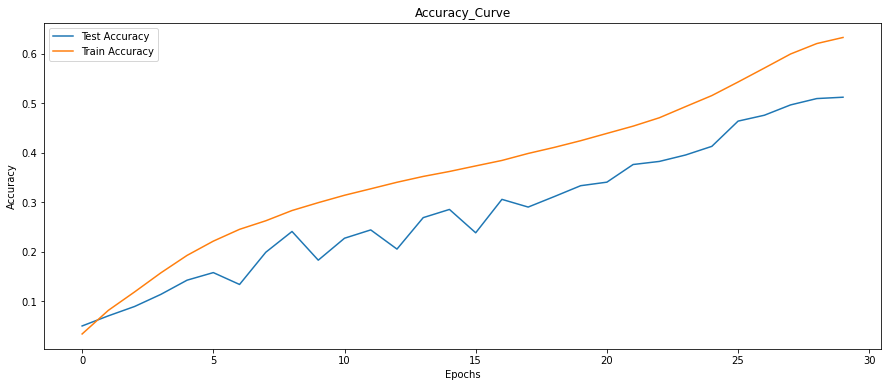

In [0]:
#cols = ["batch_train_loss", "batch_train_acc", "batch_lr","avg_test_loss", "test_acc", "train_acc", "avg_train_loss", "lr", "best_test_loss", "epochs"]
plot_graph(load_path=S12_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["test_acc", "train_acc"], legend_arr=['Test Accuracy', 'Train Accuracy'], xlabel='Epochs', ylabel='Accuracy', title='Accuracy_Curve', save_path=S12_PROJECT_PATH+'/Save_Model/')

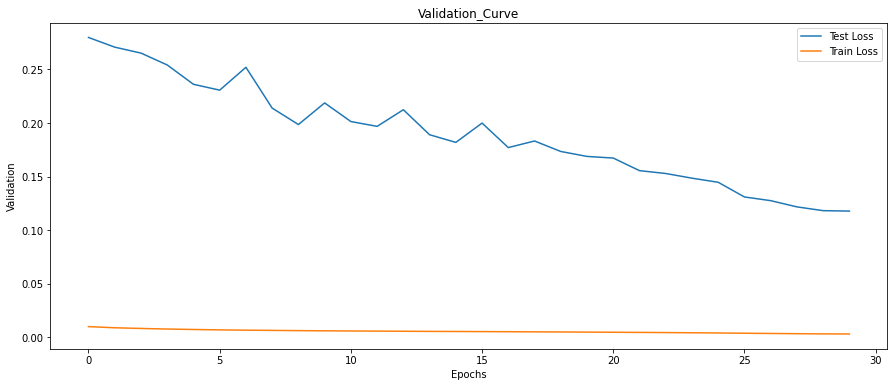

In [0]:
plot_graph(load_path=S12_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["avg_test_loss","avg_train_loss"], legend_arr=['Test Loss', 'Train Loss'], xlabel='Epochs', ylabel='Validation', title='Validation_Curve', save_path=S12_PROJECT_PATH+'/Save_Model/')

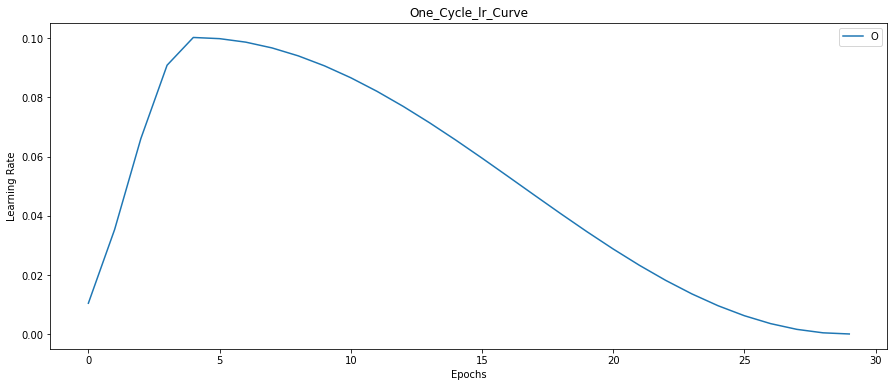

In [0]:
plot_graph(load_path=S12_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["lr"], legend_arr="One-Cycle Learning Rate", xlabel='Epochs', ylabel='Learning Rate', title='One_Cycle_lr_Curve', save_path=S12_PROJECT_PATH+'/Save_Model/')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

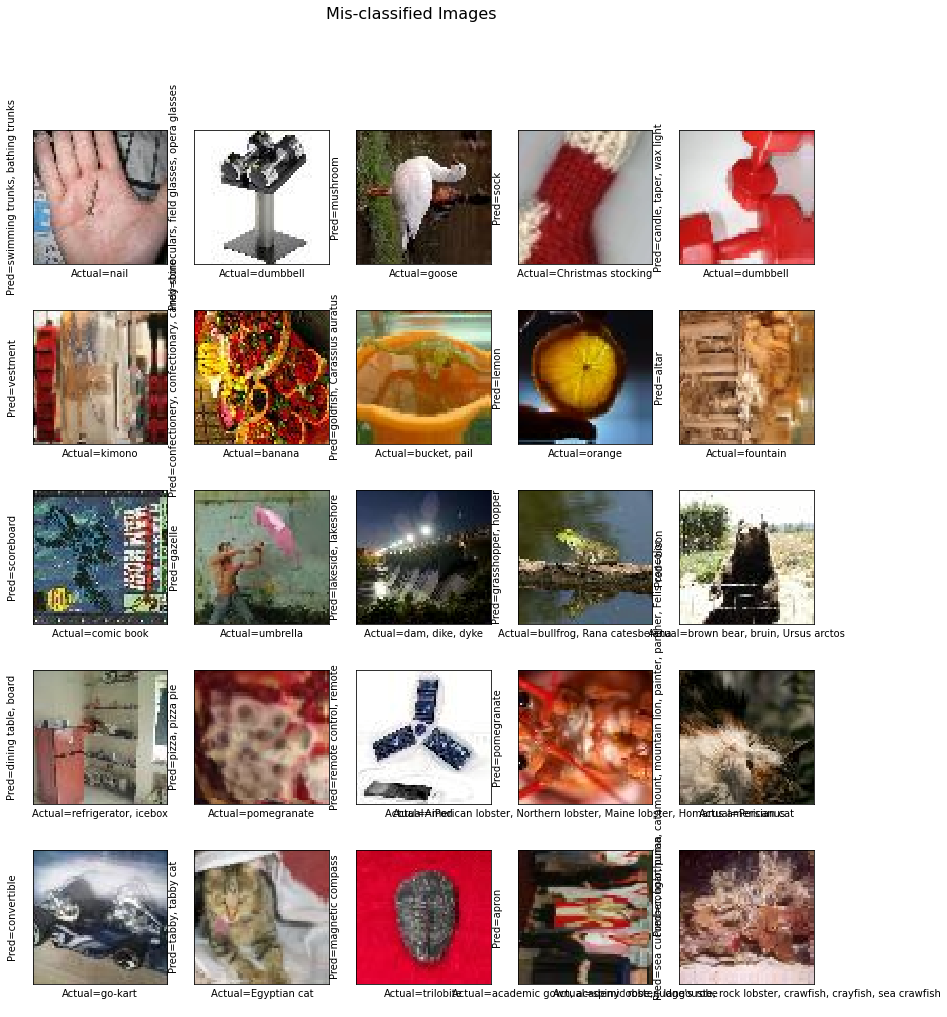

In [0]:
show_classified(MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels, classes, mean, std,"Mis-classified Images",S12_PROJECT_PATH+'/Save_Model/',25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

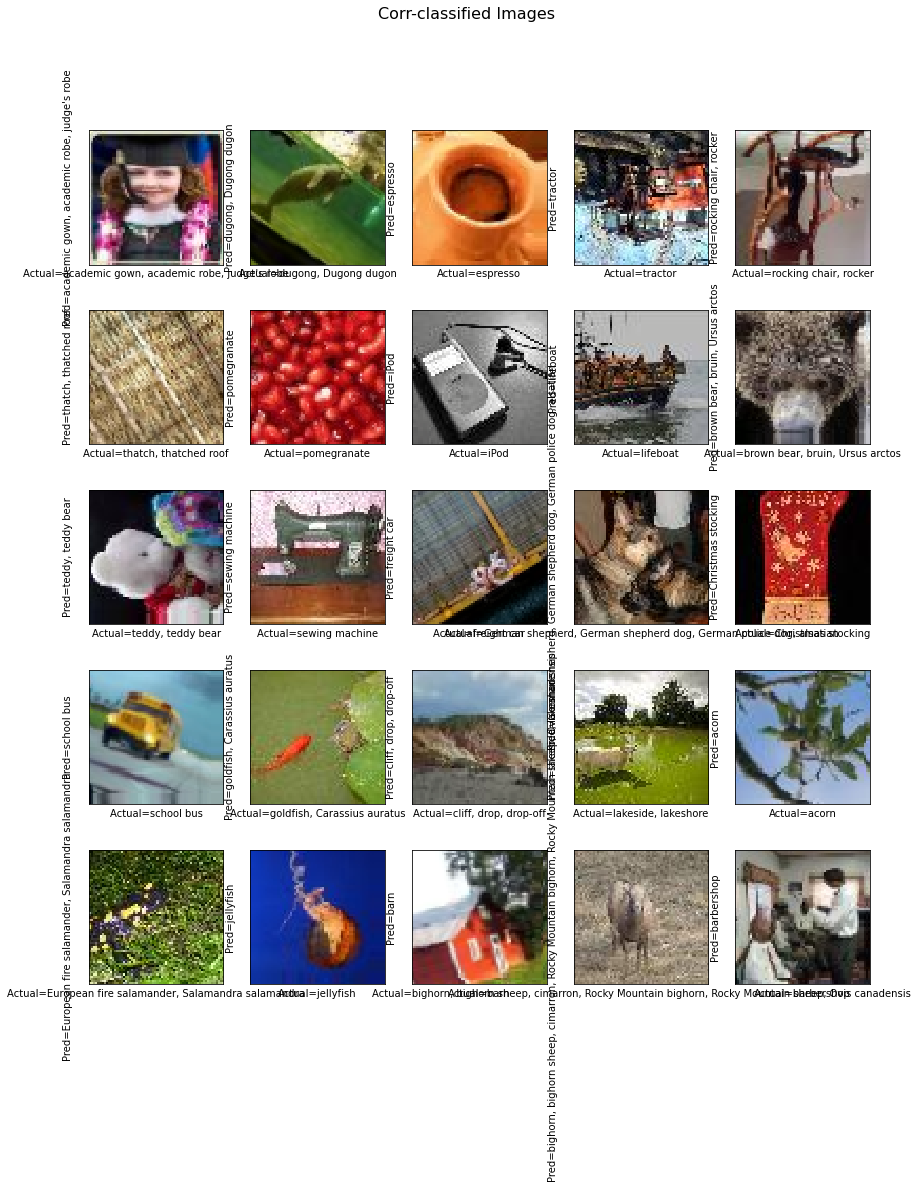

In [0]:
show_classified(CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels, classes, mean, std,"Corr-classified Images",S12_PROJECT_PATH+'/Save_Model/',25)

In [0]:
from GradCam import VisualizeCam
target_layers = ["resnet_arch.layer1", "resnet_arch.layer2", "resnet_arch.layer3", "resnet_arch.layer4"]
viz_cam = VisualizeCam(model, classes, target_layers)

In [0]:
viz_cam(MisClassifiedImages[:25], MisClassifiedTargLabels[:25], target_layers, mean, std, target_inds=MisClassifiedTargLabels[:25], metric="Incorrect", per_image=False, path=S12_PROJECT_PATH+"/Save_Model/")

Output hidden; open in https://colab.research.google.com to view.

In [41]:
viz_cam(CorrClassifiedImages[:25], CorrClassifiedTargLabels[:25], target_layers, mean, std, target_inds=None, metric="Correct", per_image=False, path=S12_PROJECT_PATH+"/Save_Model/")

Output hidden; open in https://colab.research.google.com to view.